In [23]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text

def isNaN(string):
    return string != string

In [4]:
#data from https://mri.cts-mrp.eu/portal/advanced-search
df = pd.read_excel("Downloads\MRI_EU_Dataset.xlsx")

In [5]:
df

,Productnumber,Productname,Active Substances,Dose Forms,Reference Member State (RMS),Concerned Member States (CMS),Type Level,Domain,Outcome,Date Of Outcome,Updated At
0,PT/H/0604/004,Quetiapina Aurobindo,quetiapine fumarate 200 mg,Film-coated tablet,PT - Portugal,DE - Germany | MT - Malta | XI - United Kingdo...,Abridged | Initial Application | Generic Art 1...,Human,Positive,2012-06-23 02:00:00.000,2022-03-11 13:08:38.733
1,IE/H/0201/003,Escitalopram BioOrganics 20 mgFilm Coated Tablets,escitalopram oxalate 20 mg,Film-coated tablet,IE - Ireland,NaN,Abridged | Additional Strength/Form | Generic ...,Human,Withdrawn,2010-08-11 02:00:00.000,2019-02-26 11:58:53.593
2,DE/H/3956/001,Risedronat AL 75 mg Filmtabletten,risedronate 75 mg,Film-coated tablet,DE - Germany,IT - Italy,Abridged | Initial Application | Generic Art 1...,Human,Positive,2015-04-02 02:00:00.000,2021-08-27 09:45:06.273
3,CZ/V/0160/001,Ralcam 100 mg/ml + 0.05 mg/ml solution for inj...,butafosfan 100 mg/ml | cyanocobalamin 0.05 mg/ml,Solution for injection,CZ - Czechia,DE - Germany,food | Pharmaceutical | Generic - art 13.2 Dir...,Veterinary,Positive,2019-06-03 02:00:00.000,2021-12-22 15:37:22.877
4,AT/H/0667/002,Atorvastatin Accord 20 mg Filmtabletten,atorvastatin calcium trihydrate 20.68 mg,Film-coated tablet,AT - Austria,CY - Cyprus | DE - Germany | DK - Denmark | EE...,Abridged | Initial Application | Generic Art 1...,Human,Positive,2017-06-26 02:00:00.000,2022-05-31 00:41:26.313
...,...,...,...,...,...,...,...,...,...,...,...
53336,ES/H/0864/001,Bupre - 1 A Pharma 35 Mikrogramm/Stunde transd...,buprenorphine 20 mg,Transdermal patch,ES - Spain,PT - Portugal | XI - United Kingdom (Northern ...,[not specified] | [not specified] | [not speci...,Human,Positive,2016-06-02 17:35:23.983,2022-06-17 12:03:24.613
53337,NL/H/5606/001,"Hidroferol 0,266 mg zachte capsules",calcifediol 0.27 mg,"Capsule, soft",NL - Netherlands,BE - Belgium | BG - Bulgaria | DE - Germany | ...,[not specified] | [not specified] | [not speci...,Human,Positive,2017-02-10 13:03:04.913,2022-06-16 19:25:55.757
53338,DE/H/7550/001,Escitalopram Teva20mg/ml druppels voor oraal g...,escitalopram oxalate 20 mg/ml,"Oral drops, solution",DE - Germany,NaN,[not specified] | [not specified] | [not speci...,Human,Positive,2012-11-13 11:22:40.467,2022-06-20 14:51:26.553
53339,DE/H/7551/001,"Escitalopram Teva 20 mg/ml, druppels voor oraa...",escitalopram oxalate 20 mg/ml,"Oral drops, solution",DE - Germany,NaN,[not specified] | [not specified] | [not speci...,Human,Positive,2012-11-13 11:23:23.013,2022-06-20 14:57:12.727


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53341 entries, 0 to 53340
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Productnumber                  53341 non-null  object        
 1   Productname                    53271 non-null  object        
 2   Active Substances              52950 non-null  object        
 3   Dose Forms                     53046 non-null  object        
 4   Reference Member State (RMS)   53341 non-null  object        
 5   Concerned Member States (CMS)  35118 non-null  object        
 6   Type Level                     53341 non-null  object        
 7   Domain                         53341 non-null  object        
 8   Outcome                        53341 non-null  object        
 9   Date Of Outcome                53341 non-null  datetime64[ns]
 10  Updated At                     53341 non-null  datetime64[ns]
dtypes: datetime64[n

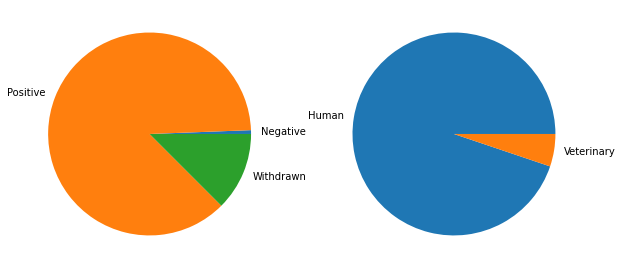

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))
ax1.pie(df.groupby("Outcome").Productname.count(), labels = df.groupby("Outcome").Productname.count().index)
ax2.pie(df.groupby("Domain").Productname.count(), labels = df.groupby("Domain").Productname.count().index);

In [21]:
#reduce to only necessary files
df =  df[(df.Outcome == "Positive") & (df.Domain == "Human")]
df.shape

(43759, 11)

In [22]:
#drop unnecessary columns
df = df.drop(columns = ["Productnumber", "Date Of Outcome", "Updated At", "Domain", "Outcome"])

In [24]:
#extract strength out of active substance section
pattern =  "[\d.]+[\s]?(?:mg \/ ml| mg \/ l| mg|mg| g \/ ml| g \/ l| g|g| µg \/ ml| µg \/ l| µg|µg| mcg \/ ml| mcg \/ l| mcg|mcg| ml|ml| l|l)"
strength = []
for info in df["Active Substances"]:
    if isNaN(info) == False:
        found = re.findall(pattern, info)
        strength.append(found)
    else: strength.append([])

#put into new column for strength 
df["strength"] = strength

In [25]:
#extract the drug out of active substance section
pattern2 = "[[A-z\s().]*?(?=[\d])"
drug = []
for sub in df["Active Substances"]:
    found = re.findall(pattern2, str(sub))
    found_stripped = [text.rstrip().lstrip() for text in found]
    found_new = [found for found in found_stripped if len(found) > 1]
    drug.append(found_new)

#put into new column for drugs
df["drug"] = drug

C:\Users\svawe\AppData\Local\Temp/ipykernel_27284/1719422792.py:5: FutureWarning: Possible nested set at position 1
  found = re.findall(pattern2, str(sub))


In [27]:
#Reset index to have proper indexes
df = df.reset_index()

In [28]:
#extract countries from concerned and reference member states
patt_countries = "(?<= - )[\w\s]*"
countries = []
for idx in df.index:
    x = []
    for country in re.findall(patt_countries, str(df["Concerned Member States (CMS)"].iloc[idx])): x.append(country)
    for country in re.findall(patt_countries, str(df["Reference Member State (RMS)"].iloc[idx])): x.append(country)

    found_stripped = [text.rstrip().lstrip() for text in x]
    countries.append(found_stripped)

#put list of countries into new column
df["country"] = countries

In [43]:
#Create a manual mapper (a DL model would probably be better at this)
mapper = {"tablet" : "Oral",
        "tablets" : "Oral",
        "capsule" : "Oral",
        "capsules" : "Oral",
        "bottle" : "Oral",
        "kit" : "Oral",
        "oral" : "Oral",
        "syrup" : "Oral",
        "chewing gum" : "Oral",
        "powder" : "Oral",
        "mdi" : "Inhalation",
        "inhalation" : "Inhalation",
        "nasal" : "Inhalation",
        "respules" : "Inhalation",
        "injection" : "Injection",
        "injections" : "Injection",
        "vial" : "Injection",
        "injection infusion" : "Injection",
        "infusion" : "Injection",
        "cartridge" : "Injection",
        "ampoule" : "Injection",
        "solution" : "Injection",
        "syringe" : "Injection",
        "tube" : "Topical",
        "gel" : "Topical",
        "eye" : "Topical",
        "ointment" : "Topical",
        "cream" : "Topical",
        "patch" : "Topical",
        "plaster" : "Topical"}

#keywords from the mapper to look for in the words
keywords = [
                "tablet", "tablets", "capsule", "capsules", "bottle", "kit", "oral", "syrup", "chewing gum", "powder", #Oral
                "mdi", "respules", "inhalation", "nasal", #Inhalation
                "injection","injections", "solution", "infusion", "vial", "injection infusion", "cartridge", "syringe", "ampoule", "syringe", #Injection
                "tube", "gel", "cream", "patch", "plaster", "eye", "oinment" #Topical
                ]

In [44]:
#get the intake router deducted from the Dose Form
mapped = []
for index in df.index:
    row = df["Dose Forms"].iloc[index]
    split = str(row).split()
    z = 0
    for word in split:
        if z == 0: #good enough if we have one of the keywords in the sentence
            word = strip_punctuation(word)
            word = word.lower()
            word = word.rstrip()
            if word in keywords:
                mapped.append(mapper[word.lower()])
                z = 1
    if z == 0: #if no keyword is in we add nan (for inference and optimization of the mapper)
        #some optimization later only a little nan is left
        mapped.append("nan")

#new variable with found routes
df["route"] = mapped

In [45]:
df.groupby("route").Productname.count()

route
Inhalation      609
Injection      3489
Oral          36949
Topical        1466
nan            1185
Name: Productname, dtype: int64

In [46]:
#most of the remaining (missed) dose forms are are missing
df[df.route == "nan"]["Dose Forms"].tolist()

[nan,
 nan,
 'Suppository',
 'Inhalations gas, liquid',
 '-',
 '-',
 '-',
 'Vaginal device',
 'Rectal foam',
 '-',
 'Lozenge',
 '-',
 'Lozenge',
 'Medicated nail laquer',
 '-',
 '-',
 '-',
 '-',
 '-',
 '[not specified]',
 '[not specified]',
 '-',
 'Nebuliser suspension',
 '-',
 '-',
 '-',
 'GRANULES IN SACHET',
 'Medicinal gas',
 '[not specified]',
 '[not specified]',
 '-',
 '-',
 '[not specified]',
 '[not specified]',
 'Medicated nail laquer',
 'Medicated nail laquer',
 'Medicated nail laquer',
 'Medicated nail laquer',
 '[not specified]',
 '[not specified]',
 '[not specified]',
 '[not specified]',
 'Medicinal gas',
 'Medicinal gas',
 'Medicinal gas',
 '[not specified]',
 'Medicinal gas',
 '-',
 'Lozenge',
 'Lozenge',
 'Compressed lozenge',
 'Sterile concentrate*',
 'Sterile concentrate*',
 'Compressed lozenge',
 'Sterile concentrate*',
 'Cutaneous foam',
 '[not specified]',
 '[not specified]',
 '[not specified]',
 'Cutaneous emulsion',
 'Cutaneous emulsion',
 'Cutaneous foam',
 'Supp

In [47]:
#we only want one row per country (as this is how our RDBMS will look)
df_exploded_c = df.explode("country")
df_exploded_c.shape

(171241, 11)

In [48]:
df_exploded_c.head()

,index,Productname,Active Substances,Dose Forms,Reference Member State (RMS),Concerned Member States (CMS),Type Level,strength,drug,country,route
0,0,Quetiapina Aurobindo,quetiapine fumarate 200 mg,Film-coated tablet,PT - Portugal,DE - Germany | MT - Malta | XI - United Kingdo...,Abridged | Initial Application | Generic Art 1...,[200 mg],[quetiapine fumarate],Germany,Oral
0,0,Quetiapina Aurobindo,quetiapine fumarate 200 mg,Film-coated tablet,PT - Portugal,DE - Germany | MT - Malta | XI - United Kingdo...,Abridged | Initial Application | Generic Art 1...,[200 mg],[quetiapine fumarate],Malta,Oral
0,0,Quetiapina Aurobindo,quetiapine fumarate 200 mg,Film-coated tablet,PT - Portugal,DE - Germany | MT - Malta | XI - United Kingdo...,Abridged | Initial Application | Generic Art 1...,[200 mg],[quetiapine fumarate],United Kingdom,Oral
0,0,Quetiapina Aurobindo,quetiapine fumarate 200 mg,Film-coated tablet,PT - Portugal,DE - Germany | MT - Malta | XI - United Kingdo...,Abridged | Initial Application | Generic Art 1...,[200 mg],[quetiapine fumarate],Portugal,Oral
1,2,Risedronat AL 75 mg Filmtabletten,risedronate 75 mg,Film-coated tablet,DE - Germany,IT - Italy,Abridged | Initial Application | Generic Art 1...,[75 mg],[risedronate],Italy,Oral


In [51]:
#create new columns for drug and strength as string
drug_new = []
for drug in df_exploded_c.drug:
    row = ", ".join([drug_part for drug_part in drug])
    drug_new.append(row)

strength_new = []
for strength in df_exploded_c.strength:
    row = ", ".join([strength_part for strength_part in strength])
    strength_new.append(row)

df_exploded_c["strength_str"] = strength_new
df_exploded_c["drug_str"] = drug_new

#drop duplicates
df_exploded_c.drop(columns = ["index", "drug", "strength"], inplace = True)
df_exploded_c = df_exploded_c.drop_duplicates()

#relist the strings created into lists
drug2 = [drug.split(", ") for drug in df_exploded_c.drug_str]
df_exploded_c["drug"] = drug2

strength2 = [strength.split(", ") for strength in df_exploded_c.strength_str]
df_exploded_c["strength"] = strength2

#drop unneeded columns and explode again
df_exploded_c = df_exploded_c.drop(columns = ['strength_str', 'drug_str', 'Active Substances', 'Dose Forms', 'Reference Member State (RMS)', 'Concerned Member States (CMS)', 'Type Level'])
df_exploded_c = df_exploded_c.reset_index().set_index(keys=["index",'country','Productname','route']).apply(lambda x: x.apply(pd.Series).stack())
df_exploded_c.shape

C:\Users\svawe\AppData\Local\Temp/ipykernel_27284/2966226379.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploded_c["drug"] = drug2
C:\Users\svawe\AppData\Local\Temp/ipykernel_27284/2966226379.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploded_c["strength"] = strength2


(219911, 2)

In [58]:
df = df_exploded_c.reset_index().drop(columns = "index")
df = df.drop(columns = ["level_4"])
df

,country,Productname,route,drug,strength
0,Germany,Quetiapina Aurobindo,Oral,quetiapine fumarate,200 mg
1,Malta,Quetiapina Aurobindo,Oral,quetiapine fumarate,200 mg
2,Portugal,Quetiapina Aurobindo,Oral,quetiapine fumarate,200 mg
3,United Kingdom,Quetiapina Aurobindo,Oral,quetiapine fumarate,200 mg
4,Germany,Risedronat AL 75 mg Filmtabletten,Oral,risedronate,75 mg
...,...,...,...,...,...
219906,Portugal,Paracetamol and Tramadol Teva 650/75 mg film-c...,Oral,tramadol hydrochloride,75 mg
219907,Slovenia,Paracetamol and Tramadol Teva 650/75 mg film-c...,Oral,paracetamol,650 mg
219908,Slovenia,Paracetamol and Tramadol Teva 650/75 mg film-c...,Oral,tramadol hydrochloride,75 mg
219909,Spain,Paracetamol and Tramadol Teva 650/75 mg film-c...,Oral,paracetamol,650 mg


In [ ]:
df[df.Productname.isna() & ~df.drug.isna()].index

In [60]:
#For all drugs that dont have a productname but a drug, take drug as productname
for index in df[df.Productname.isna() & ~df.drug.isna()].index:
    df.iloc[index].Productname = df.iloc[index].drug

In [61]:
#any missing values for drugs will be useless for our purpose, so we need to drop them
df = df.dropna(subset = ["drug"])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218561 entries, 0 to 219910
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      218561 non-null  object
 1   Productname  218561 non-null  object
 2   route        218561 non-null  object
 3   drug         218561 non-null  object
 4   strength     214790 non-null  object
dtypes: object(5)
memory usage: 10.0+ MB


In [63]:
#Still have 19000 duplicates which will cause problems. reason being that they often don't 
df[df.duplicated(keep = False)]

,country,Productname,route,drug,strength
36,Netherlands,Abiraterone 500 mg,Oral,abiraterone acetate,500 mg
37,Netherlands,"Letrozole 2,5 mg",Oral,letrozole,2.5 mg
83,Czechia,Abiraterone 250 mg,Oral,abiraterone acetate,250 mg
85,Germany,Abiraterone 250 mg,Oral,abiraterone acetate,250 mg
86,Netherlands,Abiraterone 250 mg,Oral,abiraterone acetate,250 mg
...,...,...,...,...,...
219811,Cyprus,Amoduo,Oral,bisoprolol fumarate,10 mg
219812,Greece,Amoduo,Oral,amlodipine besilate,10 mg
219813,Greece,Amoduo,Oral,bisoprolol fumarate,10 mg
219814,Hungary,Amoduo,Oral,amlodipine besilate,10 mg


In [64]:
sub = df[["Productname","country","drug"]]

In [65]:
indexes = sub[sub.duplicated(subset = ["Productname","country","drug"], keep = False)].index

In [145]:
#get synonyms for our drugs that we already collected before in our RDBMS
from sqlalchemy import create_engine
import psycopg2

conn = 'IP&PASSWORD'
engine = create_engine(conn)

sql = 'SELECT drug_name, drug_synonym FROM travel_meds.drug_synonyms'
matching = pd.read_sql(sql,engine)

In [148]:
#merge synonyms and fill unmatched synonyms
df = df.merge(matching, how = "left", left_on = "drug", right_on = "drug_synonym")
df.drug_name.fillna(df.drug, inplace = True)
df.drop(columns = ["drug", "drug_synonym"], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203004 entries, 0 to 203003
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      203004 non-null  object
 1   Productname  203004 non-null  object
 2   route        197264 non-null  object
 3   strength     193593 non-null  object
 4   drug_name    203004 non-null  object
dtypes: object(5)
memory usage: 9.3+ MB


In [149]:
#Still have a lot of duplicates
sub = df[["Productname", "country", "drug_name"]]
sub[sub.duplicated(keep = False)].shape

(36437, 3)

In [151]:
#Example for a duplicate that gave problems during loading into Postgre
df[df["Productname"] == "Vellena"]

,country,Productname,route,strength,drug_name
88858,Denmark,Vellena,Oral,30 µg,ethinyl estradiol
88859,Portugal,Vellena,Oral,30 µg,ethinyl estradiol
88995,Denmark,Vellena,Oral,20 µg,ethinylestradiol
88996,Portugal,Vellena,Oral,20 µg,ethinylestradiol


In [152]:
#Check if these indexes where strength is missing contain any with two or more drugs
indexes = sub[sub.duplicated(keep = False)].index
counts = df.iloc[indexes].groupby(["country","Productname"]).drug_name.nunique().reset_index()
counts[counts.drug_name > 1]
#lets drop these due to bad data quality and a lot of time savage for few extra medical products.

,country,Productname,drug_name
31,Austria,Atorvastatin Krka,2
262,Austria,Quetiapin Sandoz,2
404,Belgium,Atorvastatin Krka,2
445,Belgium,"Daivobet 0.5 mg, 50 µg",2
732,Bulgaria,"Daivobet 0.5 mg, 50 µg",2
1011,Cyprus,Atorvastatin Krka,2
1563,Denmark,"Amlodipin ""Actavis""",2
1734,Denmark,"Daivobet 0.5 mg, 50 µg",2
2378,Denmark,Quetiapin Sandoz,2
2630,Denmark,Zahron,2


In [153]:
droppers = counts[counts.drug_name > 1].index
df = df.drop(droppers, axis = 0)

In [154]:
#Still existing duplicates
dupes = df[df[["country", "Productname", "drug_name"]].duplicated(keep = False)]
prob_names = dupes.Productname.unique().tolist()

In [156]:
#Add strength to productname to make them unique
df["new_name"] = df["Productname"]

def merge(product, strength):
    if bool(re.search(r'\d', product)) == False:
        return str(product) + " " + str(strength)
    else: return str(product)

df["new_name"] = df.apply(lambda x: merge(x["Productname"], x["strength"]), axis = 1)

In [ ]:
df.to_csv("EU_processed.csv")